In [1]:
import src.functions as fn
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
#### Major agglomerations' latest population estimates-projections at 24/2/2021 from https://www.citypopulation.de/en/world/agglomerations/
#### NEEDS THE INITIAL VALUE OF DANGER ASCRIBED TO THE CELL (position 2 of the list)
CityInfos = { 'Sao Paulo' : [22400000, 0.7], 'Buenos Aires' : [16400000, 0], 
                'Mexico City' : [23000000, 0], 'NYC-New-JC' : [22100000, 0], 'Paris' : [11400000, 0], 
             'London' : [14800000, 0], 'Moscow' : [17300000, 0], 'Istanbul' : [16000000, 0], 
             'Lagos' : [19400000, 0], 'Johannesburg' : [13900000, 0], 'Cairo' : [21000000, 0], 
             'Tehran' : [15300000, 0], 'Shanghai' : [33600000, 0.5], 'Tokyo' : [40400000, 0], 
                'Delhi' : [30300000 ,0], 'Karachi' : [17800000, 0.9], 'Dhaka' : [20200000, 0], 
             'Seoul' : [24800000, 0] }

CityScaledInfos = {}
Cities = list( CityInfos.keys() )
CitiesScaledPops = np.round( 2.631e-6*np.array( [ i[0] for i in CityInfos.values() ] ) ).astype(int)
# CitiesScaledPops = np.round( 2.61e-7*np.array( [ i[0] for i in CityInfos.values() ] ) ).astype(int)
# CitiesScaledPops = np.round( 2e-7*np.array( [ i[0] for i in CityInfos.values() ] ) ).astype(int)
# CitiesScaledPops = np.round( 1.33e-7*np.array( [ i[0] for i in CityInfos.values() ] ) ).astype(int)
CityDangers = [ i[1] for i in CityInfos.values() ]
CityScaledInfos.update( { i[0] : [ i[1], i[2] ] for i in zip(Cities, CitiesScaledPops, CityDangers) } )

In [6]:
sum( [ CityScaledInfos[i][0] for i in CityScaledInfos ] )

1000

In [9]:
import time as tm

In [10]:
begin = tm.time()

In [7]:
Seed = 987654320
Runs = range(Seed, Seed+10)

Params = [ ['ER', 'LinDec', 'F-J', 'Triang'], ['ER', 'LinDec', 'F-J', 'Gauss'], 
       ['ER', 'LinDec', 'F-J', 'Laplace'], ['ER', 'LinDec', 'F-J', 'PwrL'],
       ['ER', 'LinDec', 'Deffuant', 'Triang'], ['ER', 'LinDec', 'Deffuant', 'Gauss'], 
       ['ER', 'LinDec', 'Deffuant', 'Laplace'], ['ER', 'LinDec', 'Deffuant', 'PwrL'], 
       ['ER', 'LinDec', 'J-A', 'Triang'], ['ER', 'LinDec', 'J-A', 'Gauss'], 
       ['ER', 'LinDec', 'J-A', 'Laplace'], ['ER', 'LinDec', 'J-A', 'PwrL'] ]

# Params = [ ['ER', 'LinDec', 'F-J', 'Triang'], ['ER', 'LinDec', 'F-J', 'Gauss'] ]


# Total run time and danger extinguishing time
T, Tnull = 100, {'Sao Paulo' : [ 60, CityScaledInfos['Sao Paulo'][1] ], 'Shanghai' : [ 80, CityScaledInfos['Shanghai'][1] ], 
                  'Karachi' : [ 90, CityScaledInfos['Karachi'][1]]}  # total run time and time at which the danger level (due to decay) becomes insignificant
Runtime = range(1,T)
CellOrder = np.array( list( CityScaledInfos.keys() ) )
# AgentCells = np.array( list( nx.get_node_attributes(AG, 'orig').values() ) )  # the network is static so the agents' position is guaranteed to remain the same
Cells = ['Shanghai', 'Karachi']  # example cells
aux = [ CellOrder == i for i in Cells ]
idx = np.any(aux, axis=0)
WhichCells = np.where( idx )[0]  # positions of example cells
AG = fn.NetworkSetup(CityScaledInfos, Type='ER', pER=2e-3)

In [12]:
#### SIMULATION
Danger, Estimate, Influence, AgDanger, AgEstimate, AgInfluence = {}, {}, {}, {}, {}, {}
for run in Runs:
    np.random.seed(run)

    for param in Params:
#         Include this block in the loop to go through the different topologies
#         AG = mn.NetworkSetup(CityScaledInfos, Type='BA', PAneig=TotPop-1 )
        AG = fn.NetworkSetup(CityScaledInfos, Type='ER', pER=2e-3)
#         AG = mn.NetworkSetup(CityScaledInfos, Type='WS', WSneig=2 )
        DistMat = np.array( nx.floyd_warshall_numpy(AG) )
        Indx = (DistMat > 0) & (DistMat != np.inf)
        DistMat[Indx] = np.round( 1/DistMat[Indx], 2 )  # matrix of inverse distances except for the Inf and zero entries
        DistMat[DistMat == np.inf] = 0  # infinite distance also results to zero distance
        
        AgDangers, AgEstimates, AgInfluences, CellDangers = {}, {}, {}, {}
        for time in Runtime:
            fn.SpatialDangerProgression(AG, time, Tnull, progression='LinDec')  # we assume only linear decay for TD for now
            
            if param[2] == 'F-J':  # influence model block
                fn.Influence(AG, DistMat, Model='F-J')
            elif param[2] == 'Deffuant':
                fn.Influence(AG, DistMat, Model='Deffuant')
            elif param[2] == 'J-A':
                fn.Influence(AG, DistMat, Model='J-A')
                
            if param[3] == 'Triang':  # personal estimation block
                fn.Estimation(AG, CityScaledInfos, Method='Triang')
            elif param[3] == 'Gauss':
                fn.Estimation(AG, CityScaledInfos, Method='Gauss')
            elif param[3] == 'Laplace':
                fn.Estimation(AG, CityScaledInfos, Method='Laplace')
            elif param[3] == 'PwrL':
                fn.Estimation(AG, CityScaledInfos, Method='PwrL')
            
            fn.AggregationMeasure(AG)
            AgDangers.update( { time : nx.get_node_attributes(AG, 'AgDanger') } )
            AgEstimates.update( { time : nx.get_node_attributes(AG, 'Estimation') } )
            AgInfluences.update( { time : nx.get_node_attributes(AG, 'Influence') } )
            CellDangers.update( { time : nx.get_node_attributes(AG, 'CellDanger') } )
            
#### END OF SIMULATION
#### AGGREGATING AGENTS PER CELL
            AgAggregateDanger, AgAggregateEstimate, AgAggregateInfluence, first = {}, {}, {}, 0
            for cell in CityScaledInfos:
                last = first + CityScaledInfos[cell][0]
                AggregateDanger = np.zeros( (len(AgDangers), len(CellOrder), CityScaledInfos[cell][0]) )
                AggregateEstimate = np.zeros( (len(AgEstimates), len(CellOrder), CityScaledInfos[cell][0]) )
                AggregateInfluence = np.zeros( (len(AgInfluences), len(CellOrder), CityScaledInfos[cell][0]) )    

                ID = range(first,last)
                for agent in enumerate(ID):  # go through the number of agents in the cell
                    AggregateDanger[:,:,agent[0]] = np.array( [ AgDangers[times][agent[1]] for times in AgDangers ] )
                    AggregateEstimate[:,:,agent[0]] = np.array( [ AgEstimates[times][agent[1]] for times in AgEstimates ] )
                    AggregateInfluence[:,:,agent[0]] = np.array( [ AgInfluences[times][agent[1]] for times in AgInfluences ] )
                first += CityScaledInfos[cell][0]

                AgAggregateDanger[cell] = np.mean( AggregateDanger, axis=2 )  # Average over all agents
                AgAggregateEstimate[cell] = np.mean( AggregateEstimate, axis=2 )
                AgAggregateInfluence[cell] = np.mean( AggregateInfluence, axis=2 )


            AggDanger, AggEstimate, AggInfluence = {}, {}, {}
            for cell in Cells:
                for tocell in WhichCells:
                    AggDanger[cell, tocell] = np.round( [ i[tocell] for i in AgAggregateDanger[cell] ], 4 )
                    AggEstimate[cell, tocell] = np.round( [ i[tocell] for i in AgAggregateEstimate[cell] ], 4 )
                    AggInfluence[cell, tocell] = np.round( [ i[tocell] for i in AgAggregateInfluence[cell] ], 4 )

#         Single agent parametrisations
        AgDanger[param[0],param[1],param[2],param[3],run] = AgDangers
        AgEstimate[param[0],param[1],param[2],param[3],run] = AgEstimates
        AgInfluence[param[0],param[1],param[2],param[3],run] = AgInfluences
#         Cell aggregates parametrisation
        Danger[param[0],param[1],param[2],param[3],run] = AggDanger
        Estimate[param[0],param[1],param[2],param[3],run] = AggEstimate
        Influence[param[0],param[1],param[2],param[3],run] = AggInfluence 

In [13]:
end = tm.time()
print(end - begin)

348.7095420360565


In [196]:
# Averaging of agent dangers for a specific cell
keys = list(AgDanger.keys())
FinAgDanger, FinAgEstimate, FinAgInfluence = {}, {}, {}
cell = np.array( list( nx.get_node_attributes(AG,'orig').values() ) )
CellIDs = np.where( cell == 'Shanghai' )[0]  # the IDs of the cell in question

for t in Runtime:
    for ag in CellIDs:
        for key1 in keys:
            tempD, tempE, tempI = [], [], []
            for key2 in keys:
                if key1[:4] == key2[:4]:
                    tempD.append( AgDanger[key2][t][ag] )
                    tempE.append( AgEstimate[key2][t][ag] )
                    tempI.append( AgInfluence[key2][t][ag] )
                    key = key1[:-1]
            FinAgDanger[key,ag,t] = np.mean( tempD, axis=0 )
            FinAgEstimate[key,ag,t] = np.mean( tempE, axis=0 )
            FinAgInfluence[key,ag,t] = np.mean( tempI, axis=0 )

Saving the averaged agent results for a specific cell

In [197]:
with open("./Data/CellAgDangers/", "w") as f:
    k = FinAgDanger.keys() 
    v = FinAgDanger.values() 
    v = [ list(i) for i in v ]
    k1 = [str(i) for i in k]
    json.dump(json.dumps(dict(zip(*[k1,v]))),f)
f.close()
    
with open("./Data/CellAgEstimations", "w") as f:
    k = FinAgEstimate.keys() 
    v = FinAgEstimate.values() 
    v = [ list(i) for i in v ]
    k1 = [str(i) for i in k]
    json.dump(json.dumps(dict(zip(*[k1,v]))),f) 
f.close()        
    
with open("./Data/CellAgInfluences", "w") as f:
    k = FinAgInfluence.keys() 
    v = FinAgInfluence.values() 
    v = [ list(i) for i in v ]
    k1 = [str(i) for i in k]
    json.dump(json.dumps(dict(zip(*[k1,v]))),f) 
f.close()    

Loading the averaged agent results for a specific cell

In [10]:
with open("./Data/CellAgDangers", "r") as f:
    data = json.load(f)
    dic = json.loads(data)
    k = dic.keys() 
    v = dic.values() 
    k1 = [eval(i) for i in k] 
    FinAgDanger = dict(zip(*[k1,v]))

with open("./Data/CellAgEstimations", "r") as f:
    data = json.load(f)
    dic = json.loads(data)
    k = dic.keys() 
    v = dic.values() 
    k1 = [eval(i) for i in k] 
    FinAgEstimate = dict(zip(*[k1,v]))
    
with open("./Data/CellAgInfluences", "r") as f:
    data = json.load(f)
    dic = json.loads(data)
    k = dic.keys() 
    v = dic.values() 
    k1 = [eval(i) for i in k] 
    FinAgInfluence = dict(zip(*[k1,v]))

In [29]:
test = np.array( list( nx.get_node_attributes(AG, 'orig').values() ) )
test2 = np.where(test == 'Karachi')
np.random.choice( np.array( list(AG.nodes) )[test2] )

840

In [35]:
WhichCells

array([12, 15])

In [175]:
# Averaging of cell aggregations
keys = list(Danger.keys())
FinDanger, FinEstimate, FinInfluence = {}, {}, {}


for cell in Cells:
    for whichcell in WhichCells:
        for i in keys:
            tempD, tempE, tempI = [], [], []
            for j in keys:
                if i[:4] == j[:4]:
                    tempD.append( Danger[j][cell, whichcell] )
                    tempE.append( Estimate[j][cell, whichcell] )
                    tempI.append( Influence[j][cell, whichcell] )
                    key = j[:-1]
            FinDanger[key,cell,whichcell] = np.mean( tempD, axis=0 )
            FinEstimate[key,cell,whichcell] = np.mean( tempE, axis=0 )
            FinInfluence[key,cell,whichcell] = np.mean( tempI, axis=0 )

Saving the cell-aggregated averaged results in JSON format

In [37]:
with open("./Data/AggregDangers", "w") as f:
    k = FinDanger.keys() 
    v = FinDanger.values() 
    v = [ list(i) for i in v ]
    k1 = [str(i) for i in k]
    json.dump(json.dumps(dict(zip(*[k1,v]))),f)
f.close()
    
with open("./Data/AggregEstimations", "w") as f:
    k = FinEstimate.keys() 
    v = FinEstimate.values() 
    v = [ list(i) for i in v ]
    k1 = [str(i) for i in k]
    json.dump(json.dumps(dict(zip(*[k1,v]))),f) 
f.close()        
    
with open("./Data/AggregInfluences", "w") as f:
    k = FinInfluence.keys() 
    v = FinInfluence.values() 
    v = [ list(i) for i in v ]
    k1 = [str(i) for i in k]
    json.dump(json.dumps(dict(zip(*[k1,v]))),f) 
f.close()    
    
with open("./Data/CellDangers", "w") as f:
    k = CellDanger.keys() 
    v = CellDanger.values() 
#     v = [ list(i) for i in v ]
    k1 = [str(i) for i in k]
    json.dump(json.dumps(dict(zip(*[k1,v]))),f)
f.close()

Loading the cell-aggregated averaged results from a JSON format

In [100]:
with open("./Data/AggregDangers", "r") as f:
    data = json.load(f)
    dic = json.loads(data)
    k = dic.keys() 
    v = dic.values() 
    k1 = [eval(i) for i in k] 
    FinDanger = dict(zip(*[k1,v]))

with open("./Data/AggregEstimations", "r") as f:
    data = json.load(f)
    dic = json.loads(data)
    k = dic.keys() 
    v = dic.values() 
    k1 = [eval(i) for i in k] 
    FinEstimate = dict(zip(*[k1,v]))
    
with open("./Data/AggregInfluences", "r") as f:
    data = json.load(f)
    dic = json.loads(data)
    k = dic.keys() 
    v = dic.values() 
    k1 = [eval(i) for i in k] 
    FinInfluence = dict(zip(*[k1,v]))
    
with open("./Data/CellDangers", "r") as f:
    data = json.load(f)
    dic = json.loads(data)
    k = dic.keys() 
    v = dic.values() 
    CellDanger = dict(zip(*[k,v]))

In [36]:
WhichCells

array([12, 15])

In [37]:
Cells

['Shanghai', 'Karachi']

In [38]:
Cell1, Cell2, Diffs, MSEs, i = [], [], {}, {}, 0
for cell in Cells:
    for prefix in Params:
        aux1 = tuple(prefix)
        aux2 = cell
        aux3 = WhichCells[0]
        aux4 = [aux1, aux2, aux3]
        name = tuple(aux4)
        if cell == Cells[0]:
            Cell1.append( name )
            Diffs[name] = np.abs( np.array( CellDanger['Shanghai'] ) - np.array( FinDanger[name] ) )
            MSEs[name] = np.mean( ( np.array( CellDanger['Shanghai'] ) - np.array( FinDanger[name] ) )**2 )
        elif cell == Cells[1]:
            Cell2.append( name )

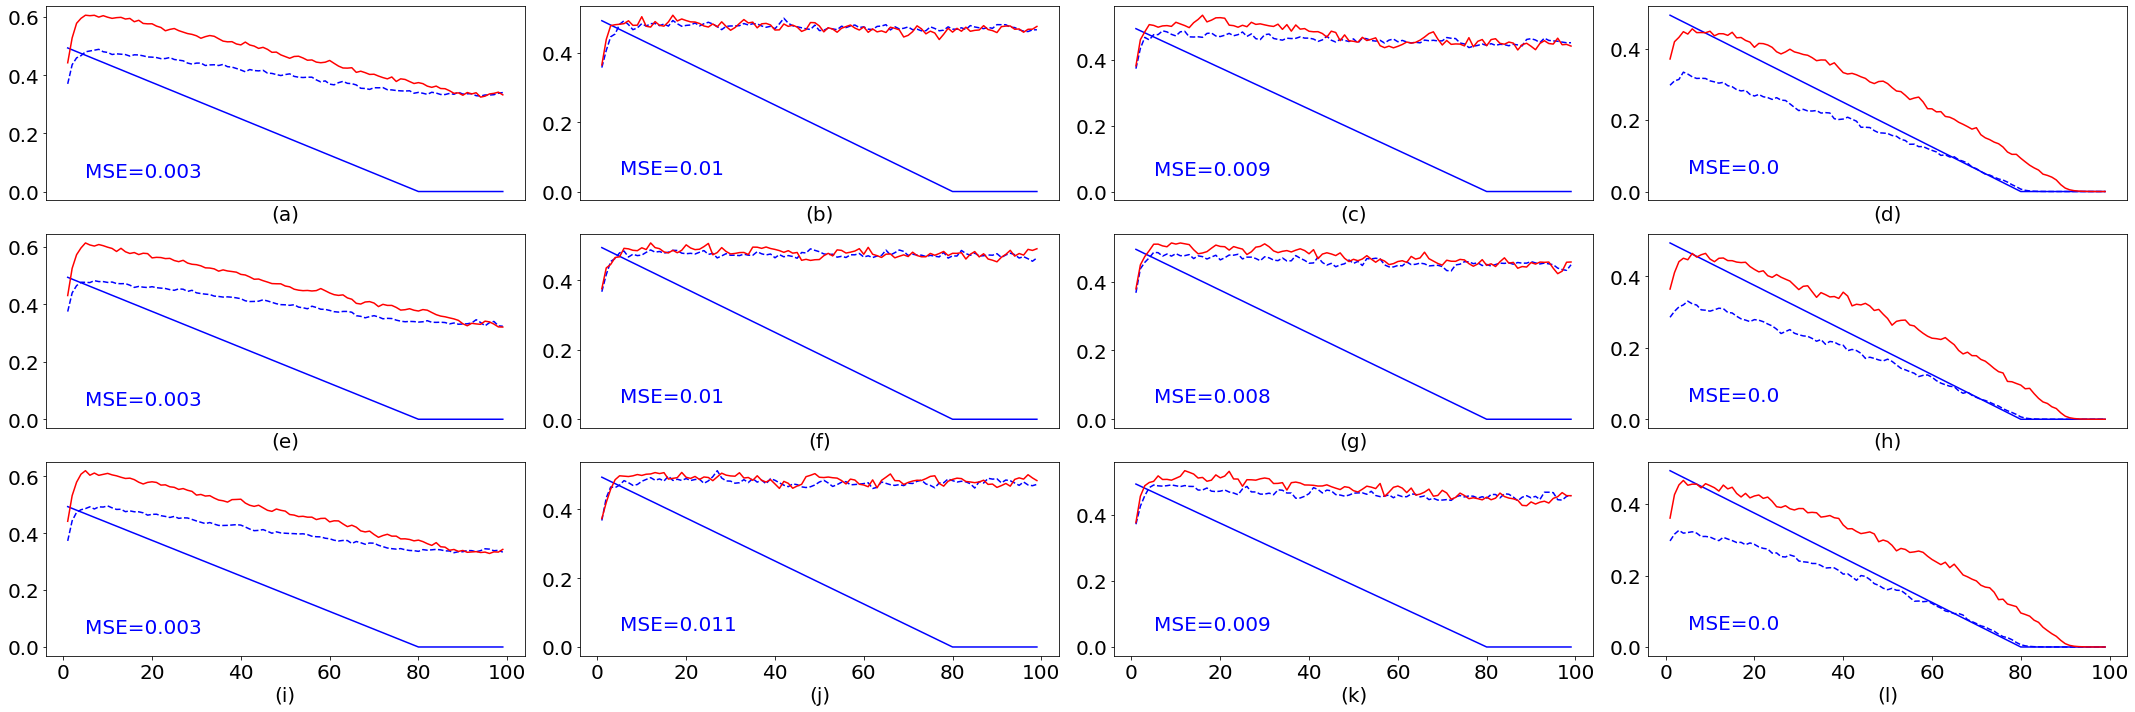

In [39]:
SubRefs = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
plt.figure(figsize=(30,10))

i, j = 1, 13  # subplot offsets

for Cell1Name,Cell2Name,subref in zip(Cell1,Cell2, SubRefs):
    
    temp = np.round( np.mean( MSEs[Cell1Name]**2 ), 3 )  # the MSE estimation

    plt.subplot(3,4,i)
    plt.plot(Runtime, CellDanger['Shanghai'], 'b', Runtime, FinDanger[Cell1Name], 'b--')
    plt.plot(Runtime, FinDanger[Cell2Name], 'r')
    plt.text(5, 0.05, 'MSE=' + str(temp), color='b', fontsize=20)
    plt.tick_params(axis='y', labelsize=20)#, labelcolor='b')
    plt.xlabel(subref, size=20)
    # plt.ylabel(r'$TD_{i}$', size=18, color='blue')
    if i > 8:
        plt.xticks(fontsize=20)
    else:
        plt.xticks([])
    # plt.legend([r'NTD$_i$'], fontsize= 12)
    # plt.twinx()
    # plt.plot(Runtime, FinDanger[('ER','LinDec','F-J','Triang'),'Karachi',WhichCells[0]], 'r')
    # plt.tick_params(axis='y', labelsize=18, labelcolor='red')
    # plt.ylabel(r'$\langle PD_{i} \rangle$', size=18, rotation=90, color='red')

#     plt.subplot(6,4,j)
#     plt.plot(Runtime, Diffs[Cell1Name], 'b')
#     plt.tick_params(axis='y', labelsize=18)
#     plt.xlabel('(b)', size=18)
#     # plt.ylabel(r'$TD_{i}$', size=18, color='blue')
#     plt.xticks(fontsize=18)

    i += 1
#     j += 1
        
plt.tight_layout()

# plt.savefig('Shanghai_Evols.png')

In [40]:
cell = np.array( list( nx.get_node_attributes(AG,'orig').values() ) )
CellIDs = np.where( cell == 'Shanghai' )[0]  # the IDs of the cell in question

In [41]:
pref = tuple( Params[0] )
ag = 561
t = 1
tup = tuple( [pref, ag, t] )

In [42]:
tup

(('ER', 'LinDec', 'F-J', 'Triang'), 561, 1)

In [43]:
# Gather all the MSEs of cell danger against agents' estimates for every t for box plot assessment criteria
MethodAllTimeEnsemb = {}
for prefix in Params[:4]:
    AllTimeEnsemb = []
    for t in Runtime:
        Ensemb = []
        for ag in CellIDs:  # gather all agents
            tup = tuple( [tuple(prefix), ag, t] )
            Ensemb.append( CellDanger['Shanghai'][t-1] - FinAgDanger[tup][WhichCells[0]] )  # the danger estimation for the cell in question
        MSE = np.mean( np.array(Ensemb)**2 )  # MSE of cell's agents for time
        AllTimeEnsemb.append( MSE )  # collection of MSEs of cell's agents for all times
    MethodAllTimeEnsemb[prefix[-1]] = np.array( AllTimeEnsemb )  # the MSE collections for every method

In [44]:
NodeSpreadsMax, NodeSpreadsMin = {}, {}
TimesMax, TimesMin = [], []

for meth in Params[:4]:
    t = np.where( MethodAllTimeEnsemb[meth[-1]] == MethodAllTimeEnsemb[meth[-1]].max() )[0] + 1  # when the MSE for the specified method is max
    print('For ',meth[-1], ' Tmax at ', t )
    TimesMax.append( t[0] )
    pref = tuple(meth)
    temp = [ FinAgDanger[tuple( [pref,ag,t[0]] )][WhichCells[0]] for ag in CellIDs ]  # collect all the danger estimates of the cell for the specified methods and time
    NodeSpreadsMax.update( {meth[-1] : temp} )
dataMax = { i : NodeSpreadsMax[i] for i in NodeSpreadsMax }

for meth in Params[:4]:
    t = np.where( MethodAllTimeEnsemb[meth[-1]] == MethodAllTimeEnsemb[meth[-1]].min() )[0] + 1  # when the MSE for the specified method is max
    print('For ',meth[-1], ' Tmin at ', t )
    pref = tuple(meth)
    TimesMin.append( t[0] )
    temp = [ FinAgDanger[tuple( [pref,ag,t[0]] )][WhichCells[0]] for ag in CellIDs ]  # collect all the danger estimates of the cell for the specified methods and time
    NodeSpreadsMin.update( {meth[-1] : temp} )
dataMin = { i : NodeSpreadsMin[i] for i in NodeSpreadsMin }

For  Triang  Tmax at  [89]
For  Gauss  Tmax at  [91]
For  Laplace  Tmax at  [93]
For  PwrL  Tmax at  [1]
For  Triang  Tmin at  [5]
For  Gauss  Tmin at  [4]
For  Laplace  Tmin at  [4]
For  PwrL  Tmin at  [92 93 94 95 96 97 98 99]


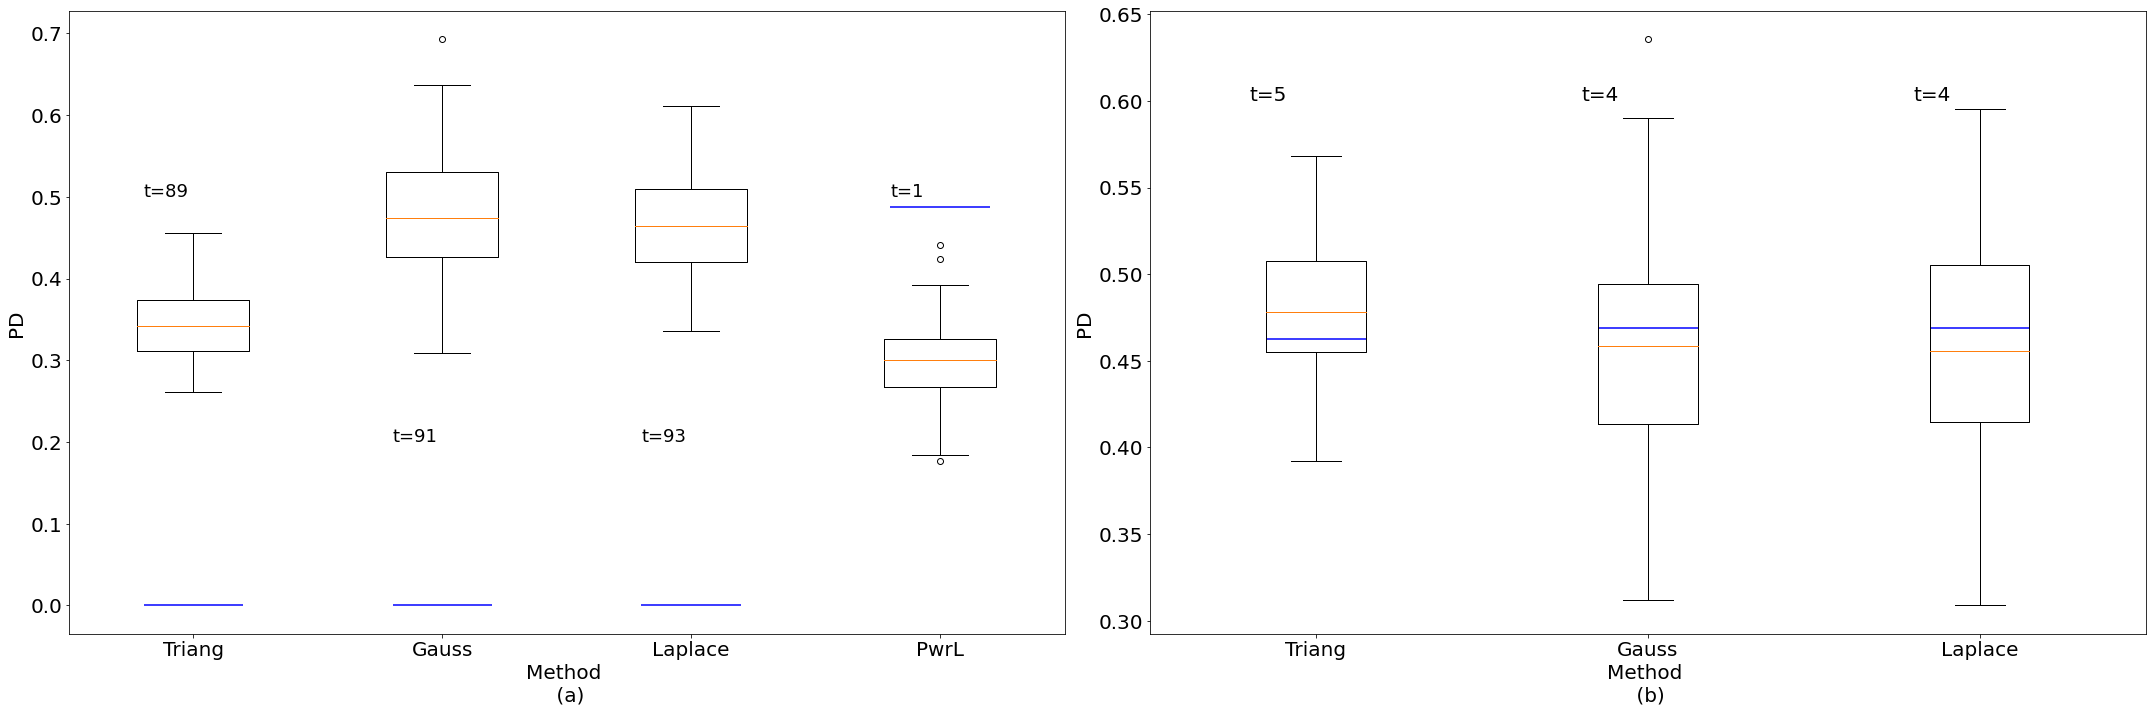

In [45]:
DataMax = list( dataMax.values() )
DataMin = list( dataMin.values() )

plt.figure(figsize=(30,10))

plt.subplot(121)
plt.boxplot(DataMax)
plt.xlabel('Method \n (a)', size=20)
plt.ylabel('PD', size=20)
plt.tick_params(labelsize=20)
plt.xticks([1,2,3,4], ['Triang', 'Gauss', 'Laplace', 'PwrL'])
for t,x,y,Xl,Xh in zip(TimesMax,[0.8, 1.8, 2.8, 3.8],[0.5, 0.2, 0.2, 0.5],[0.8, 1.8, 2.8, 3.8],[1.2, 2.2, 3.2, 4.2]):
    plt.text(x,y, 't='+str(t), fontsize=18)
    plt.hlines(CellDanger['Shanghai'][t], xmin=Xl, xmax=Xh, colors='b')  # Node danger

plt.subplot(122)
plt.boxplot(DataMin[:-1])
plt.xlabel('Method \n (b)', size=20)
plt.ylabel('PD', size=20)
plt.tick_params(labelsize=20)
plt.xticks([1,2,3], ['Triang', 'Gauss', 'Laplace'])
for t,x,y,Xl,Xh in zip(TimesMin,[0.8, 1.8, 2.8],[0.6, 0.6, 0.6],[0.85, 1.85, 2.85],[1.15, 2.15, 3.15]):
    plt.text(x,y, 't='+str(t), fontsize=20)
    plt.hlines(CellDanger['Shanghai'][t], xmin=Xl, xmax=Xh, colors='b')  # Node danger
    
plt.tight_layout()
# plt.savefig('./Manuscript/Images/ShanghaiBoxPlots')

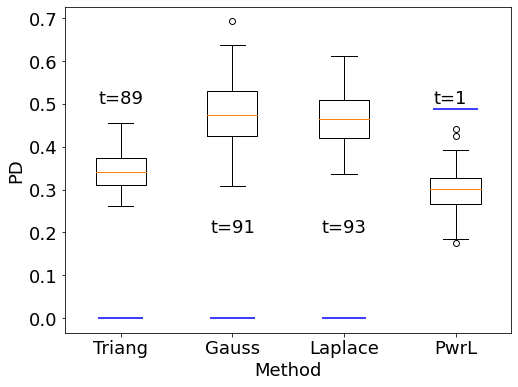

In [46]:
DataMax = list( dataMax.values() )
plt.subplots(figsize=(8,6))
# plt.title('Snapshot of agent danger spread per region', size=18)
plt.boxplot(DataMax)
plt.xlabel('Method', size=18)
plt.ylabel('PD', size=18)
plt.tick_params(labelsize=18)
plt.xticks([1,2,3,4], ['Triang', 'Gauss', 'Laplace', 'PwrL'])
for t,x,y,Xl,Xh in zip(TimesMax,[0.8, 1.8, 2.8, 3.8],[0.5, 0.2, 0.2, 0.5],[0.8, 1.8, 2.8, 3.8],[1.2, 2.2, 3.2, 4.2]):
    plt.text(x,y, 't='+str(t), fontsize=18)
    plt.hlines(CellDanger['Shanghai'][t], xmin=Xl, xmax=Xh, colors='b')  # Node danger
plt.show()

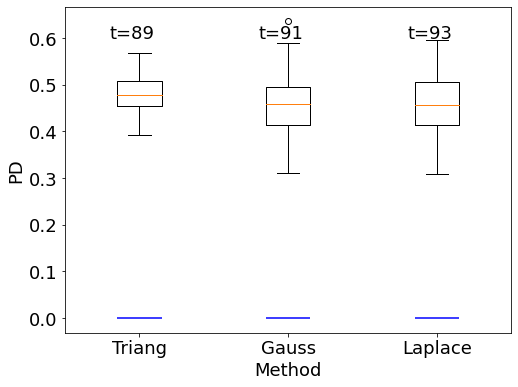

In [47]:
DataMin = list( dataMin.values() )
plt.subplots(figsize=(8,6))
# plt.title('Snapshot of agent danger spread per region', size=18)
plt.boxplot(DataMin[:-1])
plt.xlabel('Method', size=18)
plt.ylabel('PD', size=18)
plt.tick_params(labelsize=18)
plt.xticks([1,2,3], ['Triang', 'Gauss', 'Laplace'])
for t,x,y,Xl,Xh in zip(TimesMax,[0.8, 1.8, 2.8],[0.6, 0.6, 0.6],[0.85, 1.85, 2.85],[1.15, 2.15, 3.15]):
    plt.text(x,y, 't='+str(t), fontsize=18)
    plt.hlines(CellDanger['Shanghai'][t], xmin=Xl, xmax=Xh, colors='b')  # Node danger
plt.show()

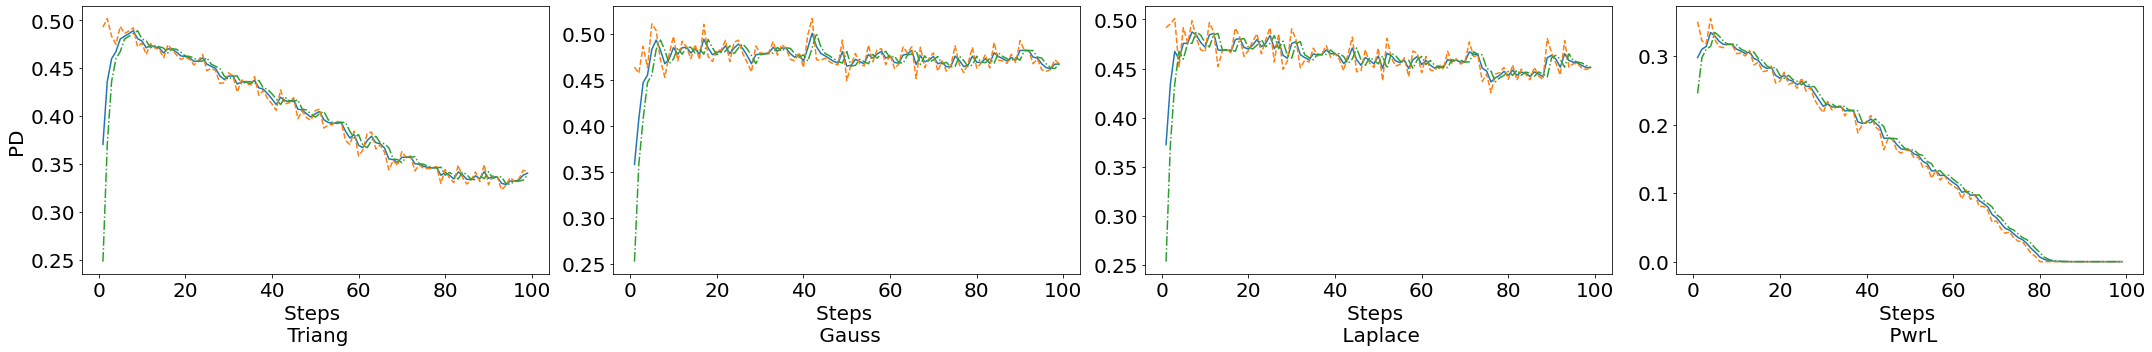

In [105]:
# Cell aggregate agent danger perception, estimate and influence for a cell
plt.figure(figsize=(30,5))

for Cell1Name in enumerate(Cell1[:4]):

    plt.subplot(1,4,Cell1Name[0]+1)
    plt.plot(Runtime, FinDanger[Cell1Name[1]])
    plt.plot(Runtime, FinEstimate[Cell1Name[1]], '--')
    plt.plot(Runtime, FinInfluence[Cell1Name[1]], '-.')
    plt.xlabel('Steps \n ' + Cell1Name[1][0][-1], size=20)
    if Cell1Name[0] == 0:
        plt.ylabel('PD', size=20)
    plt.tick_params(labelsize=20)
    plt.tight_layout()

# plt.savefig('./Manuscript/Images/PDFormation')